In [1]:
import os
import sys
sys.path.insert(0,"/home/kal/CTCF/modules/")
sys.path.insert(0,"/home/kal/CTCF/mass_CTCF/modules/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!
import tf_memory_limit
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import ctcfgen
from convnet import Bias
from keras.models import load_model
import keras.backend as K
import keras
import ucscgenome
import pandas
from scipy.special import logit
from scipy.special import expit as sigmoid
import viz_sequence


input_window = 256
batch_size = 32

model_path='/home/kal/CTCF/mass_CTCF/output/20170630_173919/20170630_173919_weights__289_0.95.hdf5'
gen_path='/home/kal/data/ctcfgen_data.hdf5'

bed_path = '/home/kal/data/final_atac.bed'
out_dir = os.path.dirname(model_path)

genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

Using TensorFlow backend.


In [2]:
# Import the model params.
model = load_model(model_path, custom_objects={'Bias':Bias})
# load the generator
gen = ctcfgen.CTCFGeneratorhdf5(gen_path)
# load the bed file
peaks = pandas.read_table(bed_path, header=None)
peaks.columns = 'chr start end ctcf pwm ml'.split()

In [3]:
def softmax(batch):
    norm_batch = []
    for seq in batch:
        norm_batch.append([_softmax(base) for base in seq])
    return np.asarray(norm_batch)
    
def _softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [4]:
intrigue = peaks[(peaks['ml'] - peaks['pwm'] > 1)]
intrigue= intrigue[(intrigue['ctcf'])]
intrigue= intrigue[(intrigue['pwm'] < 11)]
intrigue= intrigue[(intrigue['ml'] > 5)]

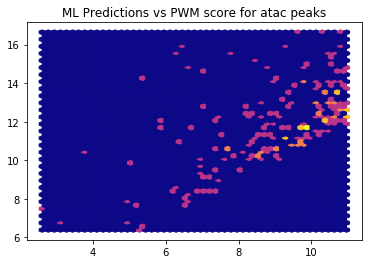

(194, 6)


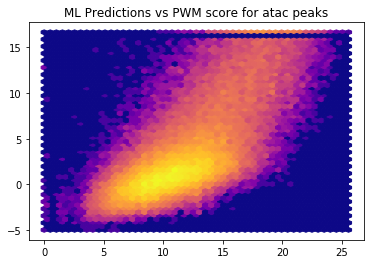

In [5]:
# make a plot of the two predictions vs each other
plt.hexbin(intrigue['pwm'].tolist(), intrigue['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()
print(intrigue.shape)

# make a plot of the two precitions vs each other
plt.hexbin(peaks['pwm'].tolist(), peaks['ml'].tolist(), gridsize=50, bins='log', cmap='plasma')
plt.title('ML Predictions vs PWM score for atac peaks')
plt.show()

In [6]:
def localize(row, verb=False):
    # break the sequence into overlapping tiles
    tile_seqs = list()
    num_tiles = int((row['end']-row['start']) / input_window) + ((row['end']-row['start']) % input_window > 0)
    if verb:
        print(num_tiles)
    for idx in range(num_tiles):
        if row['start'] + idx*input_window - input_window//2 > 0:
            seq = genome[row['chr']][row['start'] + idx*input_window - input_window//2:row['start'] + (idx+1)*input_window - input_window//2].lower()
            tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        else:
            buffered_seq = np.zeros((256,4))
            buffered_seq[:row['start'] + (idx+1)*input_window - input_window//2] = genome[row['chr']][0:row['start'] + (idx+1)*input_window - input_window//2]
            tile_seqs.append(ctcfgen.encode(np.fromstring(buffered_seq).lower(), dtype=np.uint8))
        seq = genome[row['chr']][row['start'] + idx*input_window:row['start'] + (idx+1)*input_window].lower()
        tile_seqs.append(ctcfgen.encode(np.fromstring(seq, dtype=np.uint8)))
        
    tile_seqs= np.asarray(tile_seqs)
    tile_iter = iter(tile_seqs)
    
    # get a batch generator
    batches = ctcfgen.filled_batch(tile_iter, batch_size=batch_size)
    
    # figure out where the max prediction is coming from
    preds = list()
    for batch in batches:
        preds.append(model.predict_on_batch(batch))
    preds = np.asarray(preds).reshape((-1))[:tile_seqs.shape[0]]
    
    # get a tile centered there
    max_idx = np.argmax(preds)
    max_pred = np.max(preds)
    max_tile = batch.reshape((-1, 256, 4))[max_idx]
    if verb:
        print(max_idx)
        print(max_pred)
        print(preds)
    
    return max_tile, max_pred

In [7]:
def mutagenisis(seq):
    # do a mutant scan
    mutant_window=1

    # get a mutant batch generator
    mutant_gen = ctcfgen.ngram_mutant_gen(seq, n=mutant_window)
    g = ctcfgen.filled_batch(mutant_gen, batch_size=batch_size)
    
    # base importances as large-step gradients
    # score with base there - average of scores without base there
    mutant_preds = list()
    for batch in g:
        mutant_preds.append(model.predict_on_batch(batch))

    return np.asarray(mutant_preds).reshape((-1, 4))  

In [8]:
seq_list= list()
for index, row in intrigue.iterrows():
    tile, pred = localize(row)
    seq_list.append(tile)
intrigue['signal_seq'] = seq_list

In [9]:
# write out the sequences in fasta format for further analysis
#write out a file
with open(os.path.join(out_dir, '2ndquad_seqs.fa'), 'w') as output:
    output.write('>prediction_ml|predictions_pwm\nsequence\n')
    for index, row in intrigue.iterrows():
        output.write('>'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']) + '\n')
        output.write(ctcfgen.get_string(row['signal_seq']))

        print('>'+ str(row.name) + '|' + str(row['ml']) + '-' + str(row['pwm']))
        print(ctcfgen.get_string(row['signal_seq']))

>242|11.658786881228275-9.96047
gaaattcatgaaggaatctggacatttagggggttcacagaatccgccgcttttagggaagattctctgcctgatgtgtgagcgctctaacctcttcatctgtgttcagtccccttgcaatgcttctctaaggtcggcctacatttcacttaattcagtggctctccactgggggcgctcttccccttgcaggggacatttggcaataaatgaataaatggggacatttttggttcttacaagggaggggagaggt
>534|15.536997795871244-10.3862
aagctgagaccaaatagtgtttcccaacaggtatctaagaatgtagggcaggacaattctatgctgggcaacactgtgcaggatgaatgtttagcatccctgcctctctggccctgggtgtgtaccatcaccattcccttccgtgaacaatgaaatagtcttccaaatatttctaaatgtccctagggggcagtatttcccttggctgagaaccactgggagagccacatggcccatttcattctcactctcatct
>747|10.434993429274954-8.6993
tcccgtggctcaacgattggcactgtccacttggcctccctggcctcatcctcaggccgtgcgtatcaccttttggctccacccacctgccctgggcaggaacctccaaccttggggaagcatgtagagtgctacagcgtcccctgtggtcaggtgacagaacaagtgttgaaccaggccttgcaattcttaacacagtgttctttccatcttcctcttgcttctggatcctacaaatcccaggggtttggactgg
>1185|16.635610204360294-9.66547
gagttaggactctcccctgttctcccacatagctttattgtcattttctgcccgcatctgtcctgttagcacccatcaccattaaactgtgacctctttga

In [62]:
#make an iterator
iterator = intrigue.iterrows()

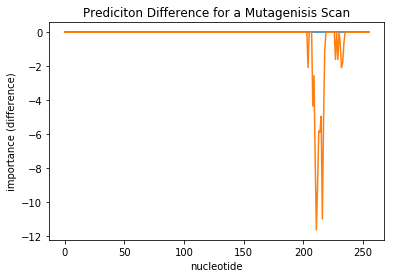

In [87]:
# pull out a sequence
index, test_row = next(iterator)
    
logit_preds = np.asarray(logit(test_row['mutant_preds']))
logit_max = test_row['ml']
if logit_max == np.inf:
    logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])

diffs = logit_preds - logit_max
orig_diffs = diffs

for x in np.nditer(diffs, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(diffs[np.where(np.isfinite(diffs))])

# plot the gain-loss curve 
plt.plot(np.amax(diffs, axis=1))
plt.plot(np.amin(diffs, axis=1))
plt.title('Prediciton Difference for a Mutagenisis Scan')
plt.ylabel('importance (difference)')
plt.xlabel('nucleotide')
plt.show()

In [88]:
def plot_key(seq, key_values, alpha=.6, background=0):
    cmap = cm.get_cmap('coolwarm')
    highlights=dict()
    
    for base, idx in zip(key_values, range(key_values.shape[0])):
        c = cmap(base)
        if abs(base - background) < .01:
            new_color = (c[0], c[1], c[2], 0)
        else: 
            new_color = (c[0], c[1], c[2], alpha)
        try:
            highlights[new_color].append([idx, idx+1])
        except KeyError:
            highlights[new_color] = [[idx, idx+1]]
    
    colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}
    
    viz_sequence.plot_weights(seq, highlight=highlights, colors=colors)
    plt.show()

Gain


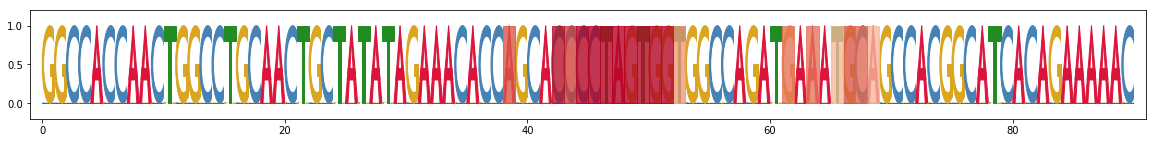

Loss


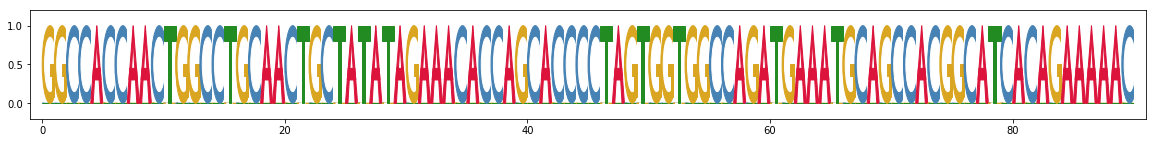

In [89]:
seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
seq = test_row['signal_seq'][seq_center-45:seq_center+45]

# get highlighted sequence
gain_values = sigmoid(np.amax(-diffs[seq_center-45:seq_center+45], axis=1))
loss_values = sigmoid(np.amax(diffs[seq_center-45:seq_center+45], axis=1))

print('Gain')
plot_key(seq, gain_values, alpha=.8, background = gain_values[0])
print('Loss')
plot_key(seq, -loss_values + 1, alpha=.8, background = -loss_values[0] + 1)

Starting sequence


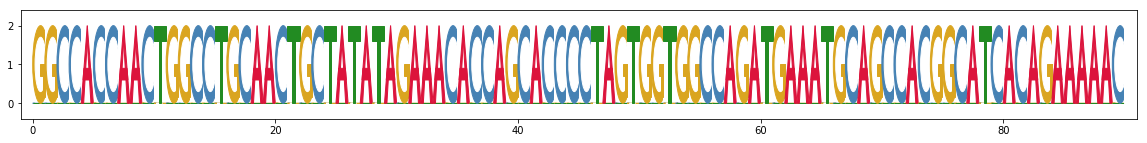

Differences


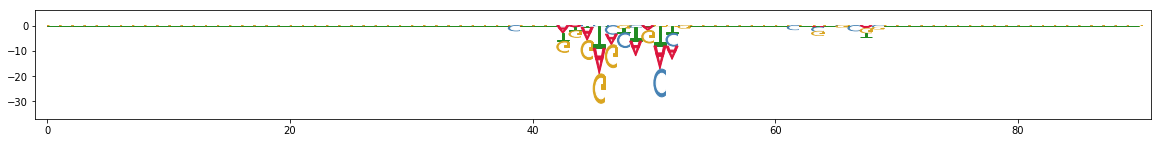

Softmax Prediction differences


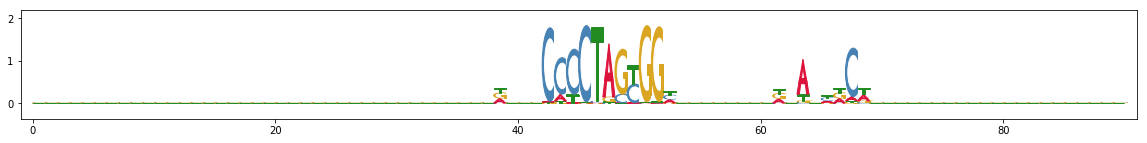

In [90]:
colors = {0:'crimson', 1:'steelblue', 2:'goldenrod', 3:'forestgreen'}

print('Starting sequence')
viz_sequence.plot_icweights(seq, colors=colors)
print('Differences')
viz_sequence.plot_weights(diffs[seq_center-45:seq_center+45], colors=colors)
# visualize predicitons
print('Softmax Prediction differences')
_ = viz_sequence.plot_icweights(np.asarray([_softmax(base*10) for base in sigmoid(diffs)])[seq_center-45:seq_center+45], colors=colors)

Average prediction difference


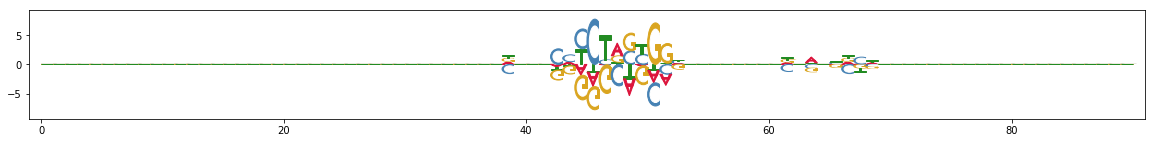

Masked average prediciton difference


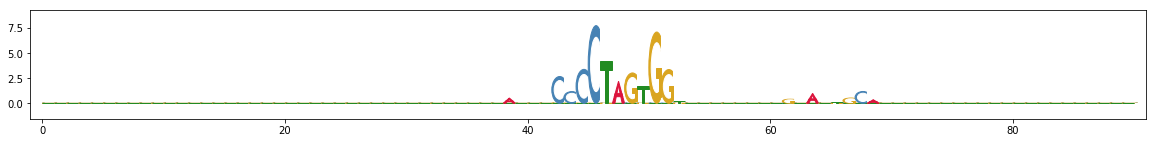

Softmax average prediction difference


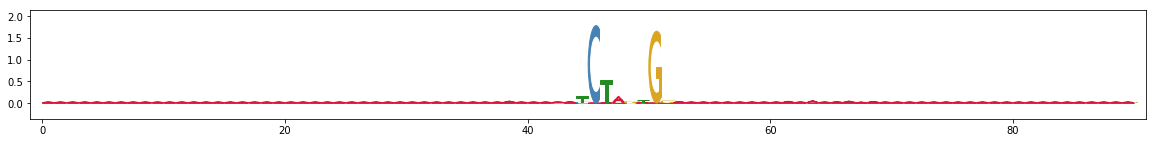

In [91]:
# plot the score differenece? 
preds = logit(test_row['mutant_preds'])[seq_center-45:seq_center+45]
for x in np.nditer(preds, op_flags=['readwrite']):
    if x == np.inf:
        x[...] = np.nanmax(preds[np.where(np.isfinite(preds))])

all_diffs = list()
for base_seq, base_preds in zip(seq, preds):
    this_base = list()
    for idx in range(4):
        this_base.append(base_preds[idx] - np.average(base_preds))
    all_diffs.append(list(this_base))

all_diffs=np.asarray(all_diffs)

print('Average prediction difference')    
viz_sequence.plot_weights(all_diffs, colors=colors)

score_diff = list()
for base_seq, base_preds in zip(seq, preds):
    idx = np.where(base_seq)
    score_diff.append(base_preds[idx] - np.average(base_preds))
      
score_diff = (seq * score_diff)
print('Masked average prediciton difference')
viz_sequence.plot_weights(score_diff, colors=colors)

print('Softmax average prediction difference')
_ = viz_sequence.plot_icweights(_softmax(all_diffs), colors=colors)

Gain


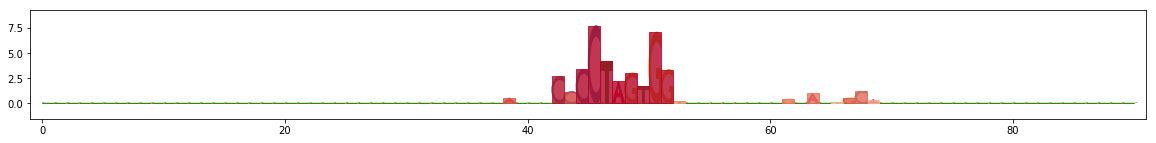

Loss


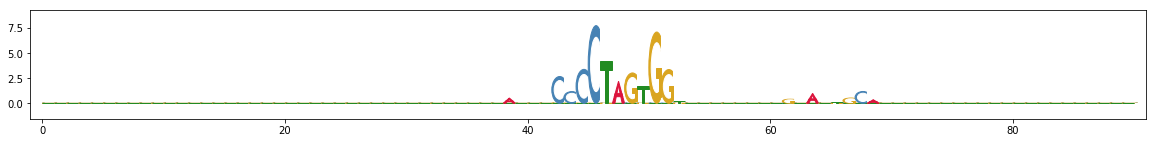

In [92]:
print('Gain')
plot_key(score_diff, gain_values, alpha=.8, background = gain_values[0])
print('Loss')
plot_key(score_diff, -loss_values + 1, alpha=.8, background = -loss_values[0] + 1)

Masked average prediciton difference


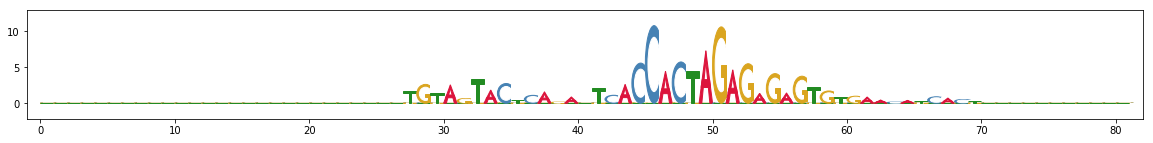

Masked average prediciton difference


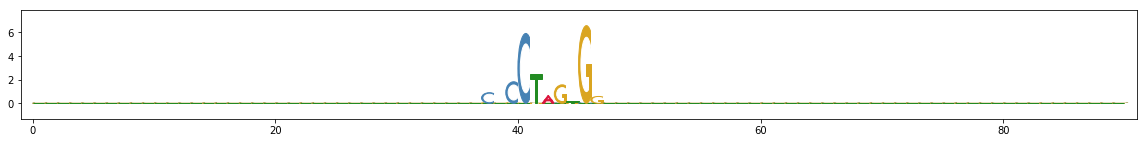

Masked average prediciton difference


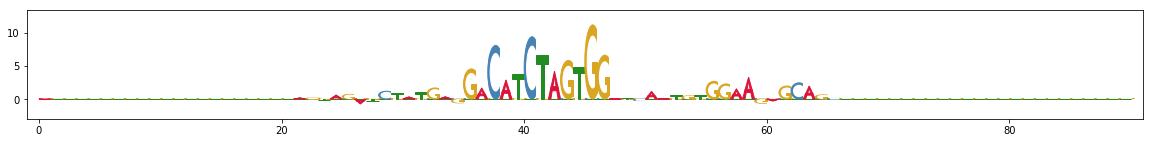

Masked average prediciton difference


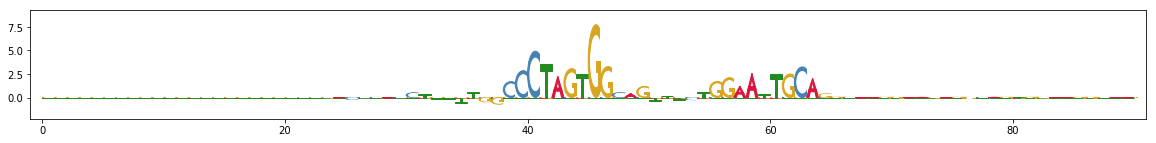

Masked average prediciton difference


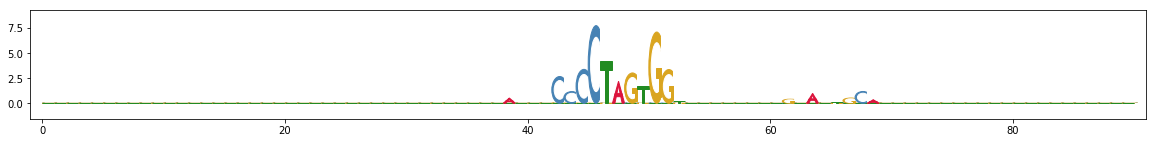

Masked average prediciton difference


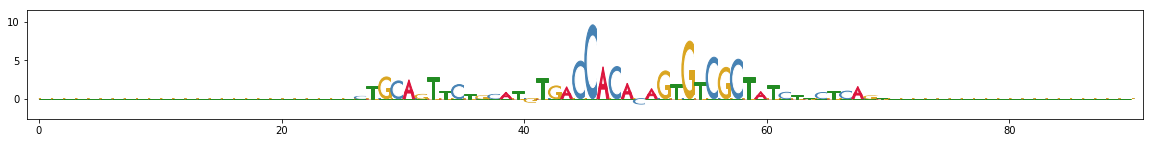

Masked average prediciton difference


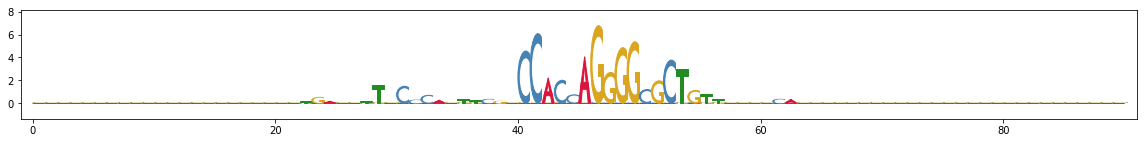

Masked average prediciton difference


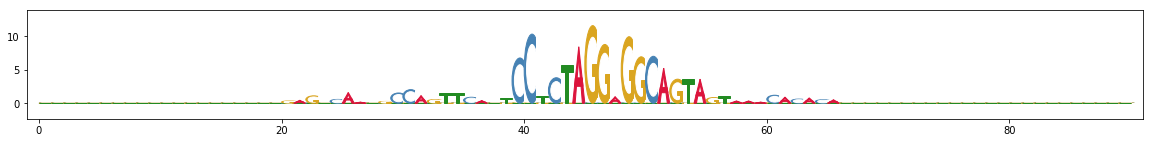

Masked average prediciton difference


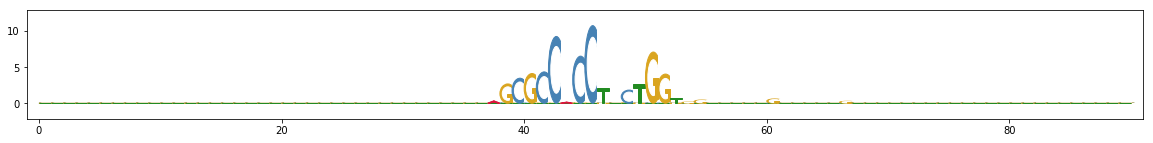

Masked average prediciton difference


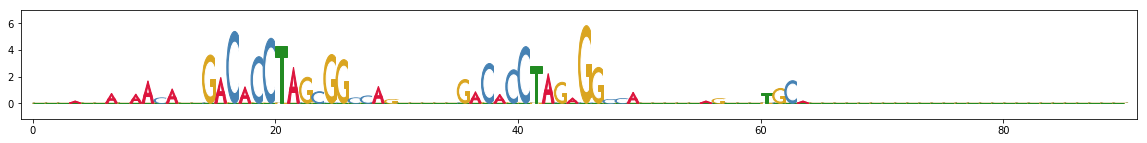

Masked average prediciton difference


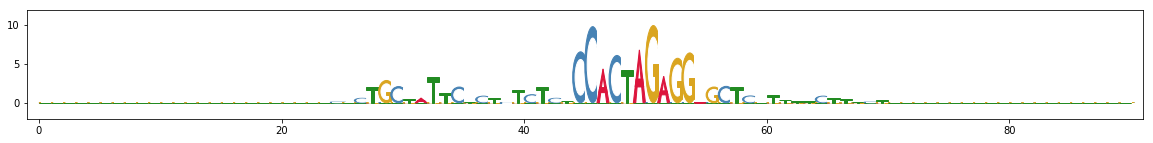

Masked average prediciton difference


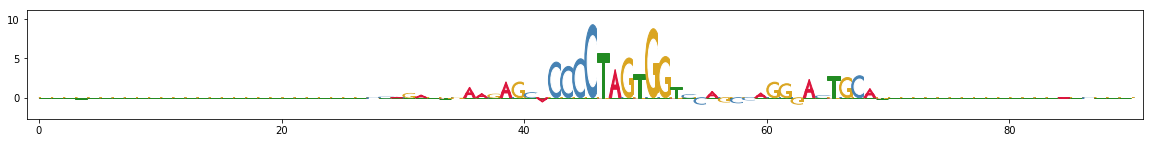

Masked average prediciton difference


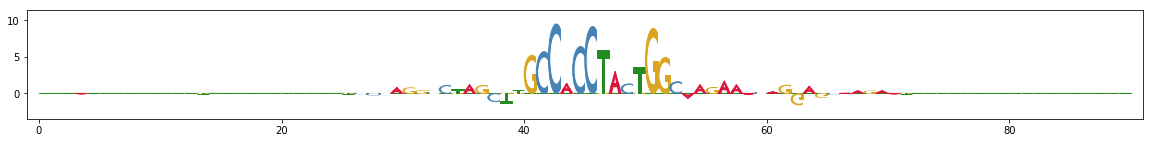

Masked average prediciton difference


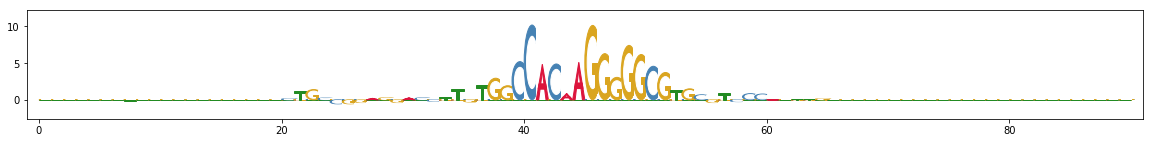

Masked average prediciton difference


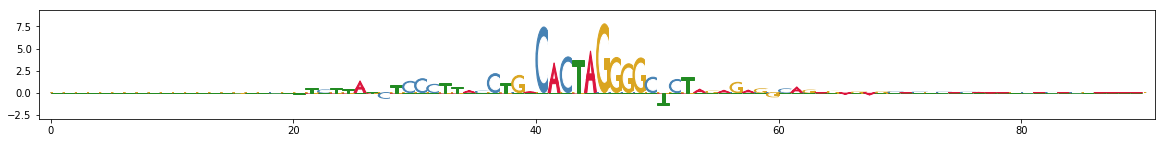

Masked average prediciton difference


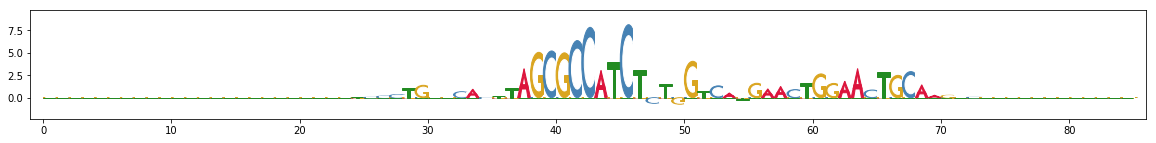

Masked average prediciton difference


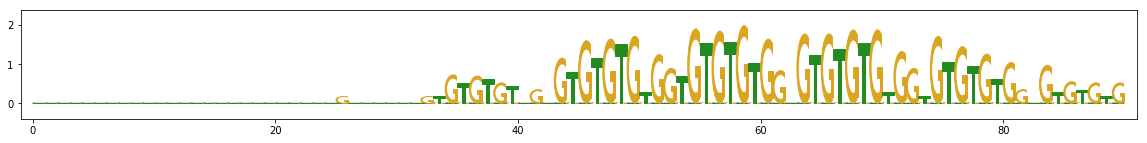

Masked average prediciton difference


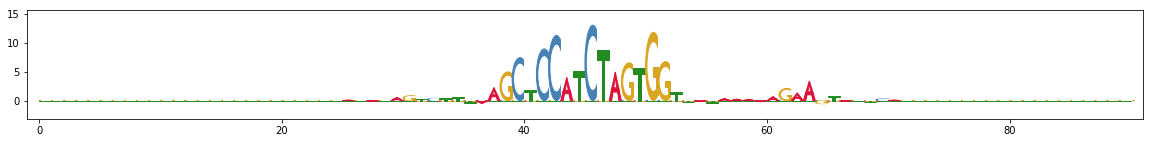

In [94]:
for index, row in intrigue.iterrows():
    # get a sequence
    seq = row['signal_seq']

    # get the center
    logit_preds = np.asarray(logit(row['mutant_preds']))
    logit_max = row['ml']
    if logit_max == np.inf:
        logit_max = np.nanmax(logit_preds[np.where(np.isfinite(logit_preds))])

    diffs = logit_preds - logit_max
    orig_diffs = diffs
    
    for x in np.nditer(diffs, op_flags=['readwrite']):
        if x == np.inf:
            x[...] = np.nanmax(diffs[np.where(np.isfinite(diffs))])

    seq_center = np.argmax(np.max(abs(diffs), axis=1), axis=0)
    seq = seq[seq_center-45:seq_center+45]
    
    # plot the score differenece? 
    preds = logit(row['mutant_preds'])[seq_center-45:seq_center+45]
    for x in np.nditer(preds, op_flags=['readwrite']):
        if x == np.inf:
            x[...] = np.nanmax(preds[np.where(np.isfinite(preds))])

    score_diff = list()
    for base_seq, base_preds in zip(seq, preds):
        idx = np.where(base_seq)
        score_diff.append(base_preds[idx] - np.average(base_preds))
      
    score_diff = (seq * score_diff)
    print('Masked average prediciton difference')
    viz_sequence.plot_weights(score_diff, colors=colors)